# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz


Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


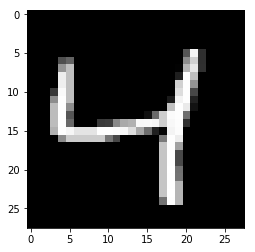

In [4]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

![Convolutional Autoencoder](assets/convolutional_autoencoder.png)

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **deconvolutional** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but it reverse. A stride in the input layer results in a larger stride in the deconvolutional layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a deconvolutional layer. Deconvolution is often called "transpose convolution" which is what you'll find with the TensorFlow API, with [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, deconvolutional layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor).

In [9]:
learning_rate = 0.001
image_size = 28
inputs_ = tf.placeholder(tf.float32, [None, image_size, image_size, 1])
targets_ = tf.placeholder(tf.float32, [None, image_size, image_size, 1])

conv_kernel_size = (3, 3)
max_pooling_size = (2, 2)

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, conv_kernel_size, padding='SAME', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, max_pooling_size, max_pooling_size, padding='SAME')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, conv_kernel_size, padding='SAME', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, max_pooling_size, max_pooling_size, padding='SAME')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, conv_kernel_size, padding='SAME', activation=tf.nn.relu)
# Now 7x7x8
encoded =  tf.layers.max_pooling2d(conv3, max_pooling_size, max_pooling_size, padding='SAME')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, [7, 7])
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, conv_kernel_size, padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, [14, 14])
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, conv_kernel_size, padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, [28, 28])
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, conv_kernel_size, padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, conv_kernel_size, padding='same')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [17]:
sess = tf.Session()

In [18]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})
        if ii == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Training loss: {:.4f}".format(batch_cost))


Epoch: 1/20... Training loss: 0.6923


Epoch: 2/20... Training loss: 0.1556


Epoch: 3/20... Training loss: 0.1343


Epoch: 4/20... Training loss: 0.1257


Epoch: 5/20... Training loss: 0.1167


Epoch: 6/20... Training loss: 0.1127


Epoch: 7/20... Training loss: 0.1125


Epoch: 8/20... Training loss: 0.1086


Epoch: 9/20... Training loss: 0.1060


Epoch: 10/20... Training loss: 0.1077


Epoch: 11/20... Training loss: 0.1032


Epoch: 12/20... Training loss: 0.1046


Epoch: 13/20... Training loss: 0.0989


Epoch: 14/20... Training loss: 0.0961


Epoch: 15/20... Training loss: 0.1003


Epoch: 16/20... Training loss: 0.0994


Epoch: 17/20... Training loss: 0.0960


Epoch: 18/20... Training loss: 0.1020


Epoch: 19/20... Training loss: 0.1009


Epoch: 20/20... Training loss: 0.0956


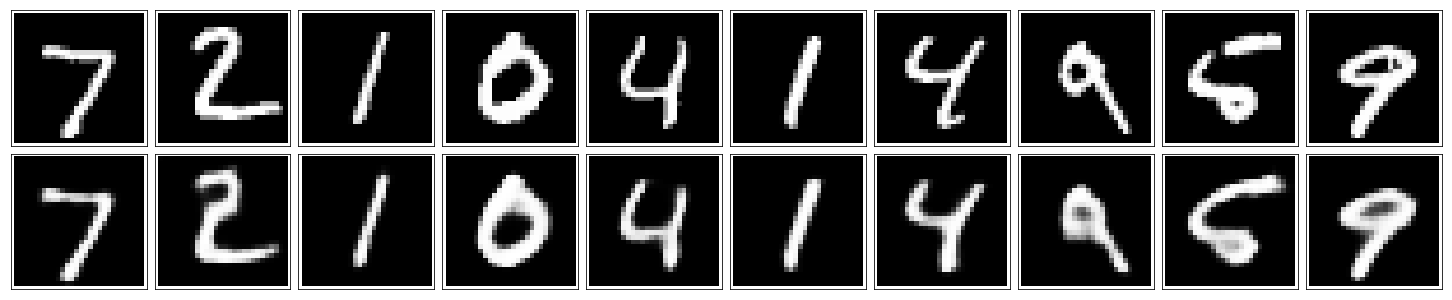

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [20]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [21]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

conv_kernel_size = (3, 3)
max_pooling_size = (2, 2)

### Encoder
conv1 =  tf.layers.conv2d(inputs_, 32, conv_kernel_size, padding='SAME', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, max_pooling_size, max_pooling_size, padding='SAME')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, conv_kernel_size, padding='SAME', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, max_pooling_size, max_pooling_size, padding='SAME')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, conv_kernel_size, padding='SAME', activation=tf.nn.relu)
# Now 7x7x16
encoded =  tf.layers.max_pooling2d(conv3, max_pooling_size, max_pooling_size, padding='SAME')
# Now 4x4x16


### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, [7, 7])
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, conv_kernel_size, padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, [14, 14])
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 16, conv_kernel_size, padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, [28, 28])
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, conv_kernel_size, padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, conv_kernel_size, padding='same')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [22]:
sess = tf.Session()

In [23]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})
        if ii == 0:
            print("Epoch: {}/{}...".format(e+1, epochs), 
                  "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6986


Epoch: 2/100... Training loss: 0.1645


Epoch: 3/100... Training loss: 0.1463


Epoch: 4/100... Training loss: 0.1314


Epoch: 5/100... Training loss: 0.1313


Epoch: 6/100... Training loss: 0.1300


Epoch: 7/100... Training loss: 0.1183


Epoch: 8/100... Training loss: 0.1199


Epoch: 9/100... Training loss: 0.1132


Epoch: 10/100... Training loss: 0.1119


Epoch: 11/100... Training loss: 0.1096


Epoch: 12/100... Training loss: 0.1106


Epoch: 13/100... Training loss: 0.1070


Epoch: 14/100... Training loss: 0.1082


Epoch: 15/100... Training loss: 0.1124


Epoch: 16/100... Training loss: 0.1056


Epoch: 17/100... Training loss: 0.1085


Epoch: 18/100... Training loss: 0.1105


Epoch: 19/100... Training loss: 0.1072


Epoch: 20/100... Training loss: 0.1085


Epoch: 21/100... Training loss: 0.1064


Epoch: 22/100... Training loss: 0.1073


Epoch: 23/100... Training loss: 0.1067


Epoch: 24/100... Training loss: 0.1015


Epoch: 25/100... Training loss: 0.1071


Epoch: 26/100... Training loss: 0.1066


Epoch: 27/100... Training loss: 0.1033


Epoch: 28/100... Training loss: 0.1023


Epoch: 29/100... Training loss: 0.1043


Epoch: 30/100... Training loss: 0.1027


Epoch: 31/100... Training loss: 0.1033


Epoch: 32/100... Training loss: 0.1018


Epoch: 33/100... Training loss: 0.1052


Epoch: 34/100... Training loss: 0.1063


Epoch: 35/100... Training loss: 0.1039


Epoch: 36/100... Training loss: 0.1016


Epoch: 37/100... Training loss: 0.1020


Epoch: 38/100... Training loss: 0.1048


Epoch: 39/100... Training loss: 0.1031


Epoch: 40/100... Training loss: 0.1012


Epoch: 41/100... Training loss: 0.1010


Epoch: 42/100... Training loss: 0.1028


Epoch: 43/100... Training loss: 0.0996


Epoch: 44/100... Training loss: 0.0983


Epoch: 45/100... Training loss: 0.1047


Epoch: 46/100... Training loss: 0.1013


Epoch: 47/100... Training loss: 0.0976


Epoch: 48/100... Training loss: 0.0996


Epoch: 49/100... Training loss: 0.1003


Epoch: 50/100... Training loss: 0.1042


Epoch: 51/100... Training loss: 0.1019


Epoch: 52/100... Training loss: 0.1014


Epoch: 53/100... Training loss: 0.1065


Epoch: 54/100... Training loss: 0.1040


Epoch: 55/100... Training loss: 0.0977


Epoch: 56/100... Training loss: 0.1028


Epoch: 57/100... Training loss: 0.1012


Epoch: 58/100... Training loss: 0.0984


Epoch: 59/100... Training loss: 0.1003


Epoch: 60/100... Training loss: 0.1011


Epoch: 61/100... Training loss: 0.0992


Epoch: 62/100... Training loss: 0.1045


Epoch: 63/100... Training loss: 0.1021


Epoch: 64/100... Training loss: 0.0987


Epoch: 65/100... Training loss: 0.1045


Epoch: 66/100... Training loss: 0.1004


Epoch: 67/100... Training loss: 0.0989


Epoch: 68/100... Training loss: 0.0995


Epoch: 69/100... Training loss: 0.0997


Epoch: 70/100... Training loss: 0.0987


Epoch: 71/100... Training loss: 0.1022


Epoch: 72/100... Training loss: 0.0982


Epoch: 73/100... Training loss: 0.0991


Epoch: 74/100... Training loss: 0.1021


Epoch: 75/100... Training loss: 0.1023


Epoch: 76/100... Training loss: 0.0986


Epoch: 77/100... Training loss: 0.0973


Epoch: 78/100... Training loss: 0.0997


Epoch: 79/100... Training loss: 0.0987


Epoch: 80/100... Training loss: 0.0993


Epoch: 81/100... Training loss: 0.0984


Epoch: 82/100... Training loss: 0.0992


Epoch: 83/100... Training loss: 0.0962


Epoch: 84/100... Training loss: 0.1003


Epoch: 85/100... Training loss: 0.1001


Epoch: 86/100... Training loss: 0.1020


Epoch: 87/100... Training loss: 0.1007


Epoch: 88/100... Training loss: 0.0989


Epoch: 89/100... Training loss: 0.0978


Epoch: 90/100... Training loss: 0.0973


Epoch: 91/100... Training loss: 0.0996


Epoch: 92/100... Training loss: 0.0988


Epoch: 93/100... Training loss: 0.0977


Epoch: 94/100... Training loss: 0.0980


Epoch: 95/100... Training loss: 0.1012


Epoch: 96/100... Training loss: 0.0994


Epoch: 97/100... Training loss: 0.0996


Epoch: 98/100... Training loss: 0.0991


Epoch: 99/100... Training loss: 0.1005


Epoch: 100/100... Training loss: 0.1000


## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

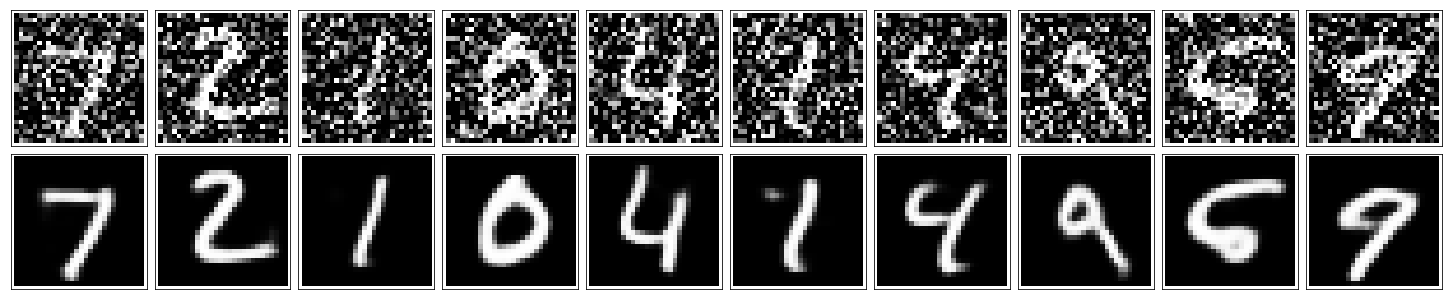

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [25]:
sess.close()